In [1]:
import os
import cv2
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from einops import repeat, rearrange

import torch
import torchvision.transforms.functional as TF
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.multimae_cam import MultiMAECAM, ActionLabelTarget, reshape_transform

from multimae.models.multimae import pretrain_multimae_base
from multimae.utils.plot_utils import plot_predictions
from pipelines.utils.data_utils import preprocess_multimae_inputs_in_batch
from pipelines.utils.model_utils import DOMAIN_CONF
from pipelines.models.student import StudentPolicy

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
flightmare_path = Path(os.environ["FLIGHTMARE_PATH"])
device = torch.device('cuda')

In [3]:
multimae_path = flightmare_path.parent / "vision_backbones/MultiMAE"
sample_rgb = multimae_path / "samples/rgb.png"
sample_depth = multimae_path / "samples/depth.npy"
sample_semseg = multimae_path / "samples/semseg.png"
sample_label = multimae_path / "samples/label.npz"

(224, 224, 3)
actions [ 1.0004072  -0.11960389 -0.03136577 -0.28045052]


(-0.5, 639.5, 479.5, -0.5)

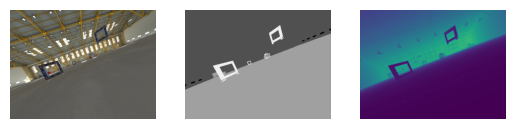

In [4]:
image = cv2.imread(str(sample_rgb))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_float = torch.from_numpy(image).float().permute(2, 0, 1) / 255.0
c, h, w = image_float.shape

image_float = TF.center_crop(image_float, min([h, w]))
image_float = TF.resize(image_float, 224)
image_float = image_float.permute(1, 2, 0).numpy().astype(np.float32)
print(image_float.shape)

state_inputs = np.load(str(sample_label))
print("actions", state_inputs["act"])

image = Image.fromarray(image)

semseg = cv2.imread(str(sample_semseg))
depth = np.load(str(sample_depth))

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image)
axs[0].axis('off')

axs[1].imshow(semseg * 80)
axs[1].axis('off')

axs[2].imshow(depth)
axs[2].axis('off')

In [5]:
DOMAINS = ['rgb']

student_save_path = flightmare_path / "flightpy/snaga_results/students/teacher_PPO_25/multivit_02-18-14-43-24"
model_cfg_path = student_save_path / "config_model.yaml"
model_config = yaml.safe_load(open(model_cfg_path, "r"))
model_name = list(model_config.keys())[0] 
student_policy = StudentPolicy(model_config, model_name)

saved_model_path = student_save_path / "model/multivit_ep063_gp_7.25_vl_0.00_10009984.pth"
saved_variables = torch.load(saved_model_path, map_location=device)
student_policy.load_state_dict(saved_variables["state_dict"], strict=True)
student_policy.to(device)
print(f"Load student policy's weights from {saved_model_path}")

Load student policy's weights from /home/chunwei/Documents/drone_offboard/flightmare_internal/flightpy/snaga_results/students/teacher_PPO_25/multivit_02-18-14-43-24/model/multivit_ep063_gp_7.25_vl_0.00_10009984.pth


In [6]:
# Pre-process RGB, depth and semseg to the MultiMAE input format

input_dict = {
    "rgb": np.expand_dims(image, [0, -1]),
    "depth": np.expand_dims(depth, [0, -1]),
    "semseg": np.expand_dims(semseg[:, :, 0], [0, 3, 4])
}

print(input_dict["rgb"].shape)
print(input_dict["depth"].shape)
print(input_dict["semseg"].shape)

input_dict = {k: np.repeat(v, 8, axis=4) for k, v in input_dict.items()}

print(input_dict["rgb"].shape)
print(input_dict["depth"].shape)
print(input_dict["semseg"].shape)

inputs = {k: torch.from_numpy(input_dict[k]) for k in DOMAINS}

(1, 480, 640, 3, 1)
(1, 480, 640, 1, 1)
(1, 480, 640, 1, 1)
(1, 480, 640, 3, 8)
(1, 480, 640, 1, 8)
(1, 480, 640, 1, 8)


In [7]:
from multimae.utils.masking_generator import non_overlap_mask_gen

torch.manual_seed(1) # change seed to resample new mask
num_encoded_tokens = 196 # the number of visible tokens
alphas = 1.0 # Dirichlet concentration parameter

mask = non_overlap_mask_gen(DOMAINS, num_encoded_tokens, patch_dims=(14, 14))

for k, v in mask.items():
    print(k, np.sum(v))
    print(v)
    
task_masks = {k: torch.LongTensor(v).flatten()[None].to(device) for k, v in mask.items()}

rgb 0.0
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [8]:
student_action = student_policy(inputs, require_grad=True, input_data_format="embed")
print(student_action.cpu().detach().numpy())

[[ 1.0034602  -0.02861676  0.06366902 -0.2721297 ]]


In [9]:
target_layers = [student_policy.embedding_layer.vit_model.encoder[-1].norm1]
action_label = torch.from_numpy(state_inputs["act"]).float().to(device)
targets = [ActionLabelTarget(action_label)]

cam = MultiMAECAM(model=student_policy,
                  target_layers=target_layers,
                  use_cuda=True,
                  reshape_transform=reshape_transform)

grayscale_cam = cam(input_tensor=inputs, targets=targets, require_grad=True, input_data_format="embed")[-1, :, :]
print(grayscale_cam.shape)
cam_image = show_cam_on_image(image_float, grayscale_cam, use_rgb=True)

(224, 224)


(-0.5, 223.5, 223.5, -0.5)

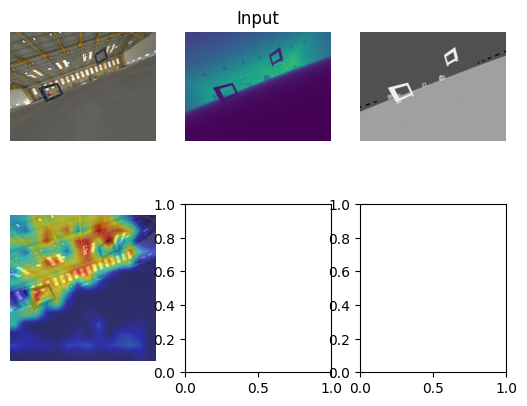

In [11]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].imshow(image)
axs[0, 0].axis('off')

axs[0, 1].imshow(depth)
axs[0, 1].axis('off')

axs[0, 2].imshow(semseg * 80)                                                                                                         
axs[0, 2].axis('off')
axs[0, 1].set_title('Input')

axs[1, 0].imshow(cam_image)
axs[1, 0].axis('off')